# Data cleaning and data wrangling on Listings database
## 1. Loading data

In [1]:
# import relevant libraries
import pandas as pd
import pandas_profiling
import math
import numpy as np

In [2]:
# read data from a zipped file to a dataframe
df = pd.read_csv('listings.csv.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False, low_memory=False)

In [3]:
# check data frame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60822 entries, 0 to 60821
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 49.2+ MB


## 2. Checking data content
The info method shows that there are 106 different columns and because of the size does not provide information for each of them. I will perform pandas_profiling on this data frame to get better idea of each column content that should allow me to drop unnecessary columns.

In [4]:
# report from pandas_profiling
df.profile_report(style={'full_width':True})

In [4]:
# using info in Variables section in pandas_profiling above, I will construct a list of columns 
#that should be definitely dropped (too many missing values or not carrying valuable for prediction info)
cols_to_drop = ['access', 'availability_60', 'availability_90', 
                'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'calendar_updated',
                'city', 'country_code','experiences_offered', 'has_availability', 'host_about', 'host_acceptance_rate',
                'host_has_profile_pic', 'host_name', 'host_listings_count', 'host_location', 'host_picture_url', 'host_thumbnail_url',
                'host_total_listings_count', 'host_url', 'interaction', 'is_business_travel_ready', 'is_location_exact',
                'jurisdiction_names', 'last_scraped', 'license', 'listing_url', 'market', 'minimum_minimum_nights', 
                'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                'maximum_nights_avg_ntm', 'medium_url', 'monthly_price', 'neighborhood_overview', 
                'neighbourhood_group_cleansed', 'notes', 'picture_url', 'requires_license', 'require_guest_profile_picture', 
                'require_guest_phone_verification', 'scrape_id', 'smart_location', 'square_feet', 'state', 'street', 
                'thumbnail_url', 'weekly_price', 'xl_picture_url'
               ]
cleaned_df = df.drop(cols_to_drop, axis = 1)

In [5]:
# checking new data frame's shape to see that the number of columns has dropped
cleaned_df.shape

(60822, 53)

## 3. Data Transformation
I have left the column 'country' in the data frame as one etry was Switzerland, while all listings are from Paris and the country needs to be France. Let's explore this column.

In [6]:
# checking row in question
cleaned_df[df.country == 'Switzerland'].loc[:,['name','price','room_type','neighbourhood']]

name   price        room_type  \
15565  Studio Buttes chaumont Paris 19ème  $59.00  Entire home/apt   

            neighbourhood  
15565  XIX Arrondissement

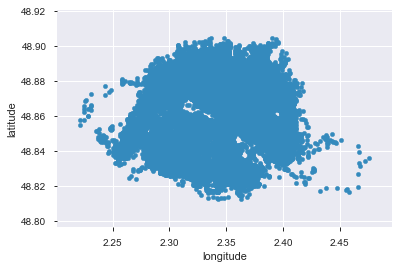

In [7]:
# checking longitude/latitude plot - to verify listing concentration
cleaned_df.plot(x='longitude', y='latitude', kind = 'scatter')

The listing looks like it is in Paris, so country name is wrong. We will keep the row and will drop the country column

In [8]:
# dropping 'country' column
cleaned_df = cleaned_df.drop(columns = ['country'])

There are two columns 'neighbourhood' and 'neighbourhood_cleansed'. The latter has no missing values and less unique names. I will keep it as is for further analysis and ML. The other column ('neighbourhood') will be compared to 'host_neighbourhood' one to create a new variable indicating whether host leaves in the same neighbourhood and use it in further work. Then both columns ('neighbourhood' and 'host_neighbourhood' will be dropped)

In [9]:
# creating new column to indicate if host is in the same neighbourhood as a listing
a = df
cleaned_df['is_host_near'] = ['t' if a.loc[x, 'neighbourhood']==a.loc[x, 'host_neighbourhood'] else 'f' for x in a.index]

# dropping 'neighbourhood' and 'host_neighbourhood' columns
cleaned_df = cleaned_df.drop(columns = ['neighbourhood','host_neighbourhood'])

There are another two columns that need transformation. These are 'host_verifications' and 'amenities'. Both contain string values that look like a list of methods by which hosts were verified and amenities in specific listing correspondingly. I will first convert each of the columns to actual list of lists (will use a function for that) and then will transform 'host_verifications' column to represent amount of verification methods each host has. For 'amenities' I wiil create a new column 'amenities_count' and will keep the original column (transformed to list of lists).

In [10]:
# define function that transforms column from list of list like strings to list of lists
def str_to_list(col_name, df):
    """Transform specified column in specified dataframe from list of list like stringd to list of lists"""
    new_col = df[col_name].str.strip('][}{')
    new_col = new_col.str.replace('\'','')
    new_col = new_col.str.replace('\"','')
    new_col = new_col.str.split(',')
    return new_col

In [11]:
# apply function to columns in question
col_names = ['host_verifications', 'amenities']
for col in col_names:
    cleaned_df[col] = str_to_list(col, df)

In [12]:
# define function that maps column containing lists to column with corresponding list lenths
def list_to_int(col_name, df):
    """Return list of lengths of each list in specified column in specified dataframe"""
    return [len(x) for x in df[col_name]]

In [13]:
# applying above function to given columns, replacing one and creating a new one for another
cleaned_df['host_verifications'] = list_to_int('host_verifications', df)
cleaned_df['amenities_count'] = list_to_int('amenities', df)

Another group of columns that requires transformation prior to further analysis contains price values (for listing price, security deposit, cleaning fee and extra people fee). All of these three columns have prices represented by strings starting with '$'. Below function will help to transform the strings to numeric values. Also for missing values in 'security_deposit' and 'cleaning_fee' columns I will use 0's to fill them in as some listings do not have those charges associated with them and in this case they are typically not entered.

In [14]:
# defining function that transforms column with string prices to numeric prices
def str_to_num(col_name, df):
    """Return a new column with numeric prices that correspond given string values in specified column"""
    df[col_name] = df[col_name].fillna('$0.00')
    new_col = df[col_name].str.strip('$')
    new_col = new_col.str.replace(',','')
    new_col = pd.to_numeric(new_col)
    return new_col

In [15]:
# applying defined function to columns in question
col_names = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
for col in col_names:
    cleaned_df[col] = str_to_num(col, df)

## 4. Filling in Missing Values
Lots of columns have missing values. In this section I will meaningfully fill in them. For the ease of the process I will define function that fills NAN values with a given value for a given column in given dataframe. Then I will apply this function to groups of columns (grouped by the value that is being filled in)

In [16]:
# defining a function that fills in missing values for a given one
def fill_nans(col_name, df, value):
    """Fill missing values with specified value in specified column of specified dataframe"""
    return df[col_name].fillna(value)

There is a group of columns ('name', 'summary', 'space', 'description', 'transit', 'house_rules') that each contain some sort of listing description. All of entries of this columns are strings. Missing values will be filled in with empty strings.

In [17]:
# filling missing values with empty string for mentioned columns
col_names = ['name', 'summary', 'space', 'description', 'transit', 'house_rules']
for col in col_names:
    cleaned_df[col] = fill_nans(col, df, '')

For the following two columns I will fill in NANs with 'f' indicating that the feature is not present.

In [18]:
# filling missing values with 'false'
col_names = ['host_is_superhost', 'host_identity_verified']
for col in col_names:
    cleaned_df[col] = fill_nans(col, df, 'f')

Next columns where missing values need to be filled are also related to information about host. However, each of them will be filled differently. 

For example, NANs in 'host_response_time' will be substituted by 'unknown' to be able to further categorize this column. 

For 'host_response_rate' on contrary I will use average response rate to fill in missing values.

'host_since' column contains date info and for filling missing values I will use manually calculated median.

In [19]:
# filling missing values in 'host_response_time'
cleaned_df.host_response_time = fill_nans('host_response_time', df, 'unknown')

# filling missing values for 'host_response_rate', first converting from string to decimal
temp_col = pd.to_numeric(df.host_response_rate.str.strip('%'))/100
cleaned_df.host_response_rate = temp_col.fillna(temp_col.mean())

# filling missing values for 'host_since' column, first converting from string to datetime
temp_col = pd.to_datetime(df.host_since)
# calculating 'median' of above column values manually
avg_date = temp_col.sort_values()[int(len(temp_col)/2)]
# filling missing values with calculated median
cleaned_df.host_since = fill_nans('host_since', df, avg_date)

The next set of columns describes size of the listing. It includes the following columns 'accommodates' (has no missing values and will be used to fill out missing values in other columns), 'bedrooms', 'bathrooms' and 'beds'. I will deal with missing values the following way:
1. 'bedrooms' column - maximum of ('accommodates'/2) and 1
2. 'bathrooms' column - maximum of ('bedrooms' - 1) and 1
3. 'beds' column - maximum of 'bedrooms' and 1

In [20]:
# filling missing values for three indicated above columns
for i in cleaned_df.index:
    if math.isnan(cleaned_df.loc[i, 'bedrooms']):
        a = cleaned_df.loc[i, 'accommodates']
        cleaned_df.loc[i, 'bedrooms'] = max(int(a/2),1)
    if math.isnan(cleaned_df.loc[i, 'bathrooms']):
        b = cleaned_df.loc[i, 'bedrooms']
        cleaned_df.loc[i, 'bathrooms'] = max(a-1,1)
    if math.isnan(cleaned_df.loc[i, 'beds']):
        cleaned_df.loc[i,'beds'] = cleaned_df.loc[i, 'bedrooms']

One more set of columns contains information about reviews, which include review ratings on various aspects of the listing (value, communication, cleanliness etc.) and information about reviews itself (dates of first and last review, number of reviews per month).
1. for the ratings columns I will fill in NANs with average rating in the category
2. 'reviews_per_month', 'first_review' and 'last_review' NANs will be filled in with '0's which will correspond to the fact that these listings don't have any reviews

In [21]:
# filling missing values with averages in ratings_score columns
col_names = ['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']
for col in col_names:
    avg = df[col].mean()
    cleaned_df[col] = fill_nans(col, df, avg)

# filling missing values with '0's in corresponding columns
col_names = ['reviews_per_month', 'first_review', 'last_review']
for col in col_names:
    cleaned_df[col] = fill_nans(col, df, 0)

There are two columns left that still contain missing values. They are 'cancellation_policy' and 'zipcode'. I will fill NANs in both of them with corresponding mode values.

In [22]:
# filling missing values with mode values of corresponding columns
col_names = ['cancellation_policy', 'zipcode']
for col in col_names:
    md = df[col].mode()[0]
    cleaned_df[col] = fill_nans(col, df, md)

Quick check that there are no missing values

In [23]:
# checking the whole dataframe for NANs
cleaned_df.isnull().values.any()

False

## 5. Exploring outliers
Now that there are no missing values, it is time to check for outliers.
First, I will check the target column 'price'. Price is very scewed and has a lot of outliers on the right. In this situation it makes sense to explore log(price) instead. There are 8 rows with price = 0 (when transforming to log it will mp to -inf which won't translate well) and it is reasonable to drop them (also not much sense in free listings). 

There are 3 different room types (entire home, private room and shared room). For proper outlier exploration it makes sense to separate these categories and to define a function that explores each of them.

In [24]:
# dropping rows where price = 0
to_drop = cleaned_df[cleaned_df.price == 0]
cleaned_df = cleaned_df.drop(to_drop.index)

room_type
Entire home/apt    AxesSubplot(0.125,0.125;0.775x0.755)
Private room       AxesSubplot(0.125,0.125;0.775x0.755)
Shared room        AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

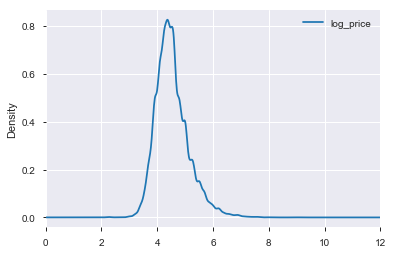

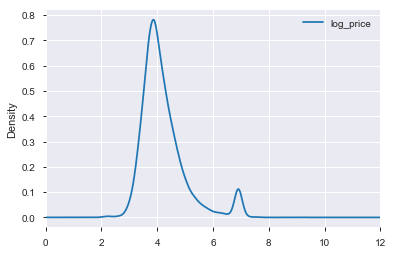

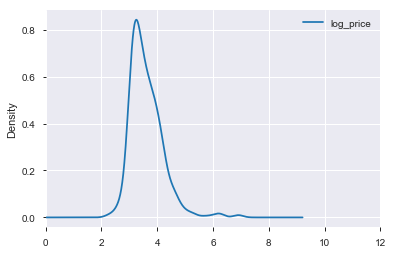

In [25]:
# transforming to log price - adding a column to data base
cleaned_df['log_price'] = np.log(cleaned_df.price)

# plotting log prices for each room type
temp = cleaned_df.loc[:,['room_type', 'log_price']]
temp.groupby('room_type').plot(kind='kde',xlim=(0,12))

In [26]:
# defining function to explore outliers in given room type category and removing them if there are less than 1% of data
def explore_outliers(room_type):
    """Print information about outliers and return pandas Series of outliers in specified room type category"""
    x = cleaned_df[cleaned_df.room_type == room_type].loc[:,['log_price', 'price']]
    std = x.log_price.std()
    mean = x.log_price.mean()
    lower, upper = mean - 3*std, mean + 4*std # since data is scewed to the right, the upper boundry will be further from mean
    left_outliers = x[x.log_price <= lower]
    right_outliers =x[x.log_price >= upper]
    print('\n In the '+room_type+' price category there are '+str(len(left_outliers))+' left outliers ranging from $'+
         str(left_outliers.price.min())+' to $'+str(left_outliers.price.max())+
          ' and there are '+str(len(right_outliers))+' right outliers ranging from $'+
          str(right_outliers.price.min())+' to $'+str(right_outliers.price.max()))
    all_outliers = left_outliers.append(right_outliers)
    #all_outliers.log_price.plot('hist', bins = 100, legend = True)
    outliers_num =len(all_outliers)/len(cleaned_df[cleaned_df.room_type == room_type])
    print('The outliers make '+str(round(outliers_num*100,2))+'% of the data in the corresponding room type category.')
    if outliers_num < 0.01:
        cleaned_df.drop(all_outliers.index)
        print('There are less than 1% outliers and they were removed from the data.')
    else:
        print('There are more than 1% of outliers. Data needs further exploration.')
    return all_outliers.price

In [27]:
# exploring outliers for each room category
room_types = ['Entire home/apt', 'Private room', 'Shared room']
price_outliers = []
for rt in room_types:
    price_outliers.append(explore_outliers(rt))


 In the Entire home/apt price category there are 33 left outliers ranging from $9.0 to $15.0 and there are 136 right outliers ranging from $1029.0 to $9379.0
The outliers make 0.32% of the data in the corresponding room type category.
There are less than 1% outliers and they were removed from the data.

 In the Private room price category there are 0 left outliers ranging from $nan to $nan and there are 7 right outliers ranging from $1800.0 to $8887.0
The outliers make 0.09% of the data in the corresponding room type category.
There are less than 1% outliers and they were removed from the data.

 In the Shared room price category there are 0 left outliers ranging from $nan to $nan and there are 5 right outliers ranging from $500.0 to $1000.0
The outliers make 1.08% of the data in the corresponding room type category.
There are more than 1% of outliers. Data needs further exploration.


Only 'Shared room' category has slightly over 1% outliers and there were left in the data frame. There are only 5 of them so it is worth to take a closer look at them.

In [28]:
# explore outliers in Shared room category
shared = cleaned_df[(cleaned_df.room_type == 'Shared room')&(cleaned_df.price >= 500)].loc[
    :,['price', 'bedrooms', 'property_type', 'name', 'number_of_reviews']]
shared

price  bedrooms property_type                   name  \
7315    500.0       1.0         Igloo  Le pole nord  à Paris   
31302   530.0       1.0     Apartment      PARIS EST MAGIQUE   
52682  1000.0       1.0        Hostel     Bed in 12-Bed Dorm   
52684  1000.0       1.0        Hostel     Bed in 10-Bed Dorm   
55709   500.0       1.0     Apartment        Bug Bounty Test   

       number_of_reviews  
7315                   0  
31302                  0  
52682                  3  
52684                  0  
55709                  0

All above listings look out of place and it is fine to drop them.

In [29]:
# dropping outliers in Shared room category
cleaned_df = cleaned_df.drop(shared.index)

There are several other columns, like 'accommodates', 'bedrooms' etc. that need to be explored for outliers. The function 'explore_outliers' defined above can be modified to explore outliers in any given numeric column. Since the rows can overlap for different columns, this new function will only make suggestions about dropping outliers. Also all outliers are on the right in these columns, so will only check those

In [30]:
# defining a more general function to explore outliers
def explore_outliers_gen(col_name):
    x = cleaned_df[col_name]
    std = x.std()
    mean = x.mean()
    upper = mean + 3*std
    outliers = x[x >= upper]
    print('\n In the column '+col_name+ ' there are '+str(len(outliers))+' outliers ranging from '+
         str(outliers.min())+' to '+str(outliers.max())+
          '.')
    outliers_num =len(outliers)/len(x)
    print('The outliers make '+str(round(outliers_num*100,2))+'% of the data in the corresponding column.')
    if outliers_num < 0.005:
        print('There are less than 0.5% outliers and can be removed from the data.')
        return outliers
    else:
        print('There are more than 0.5% of outliers. Data needs further exploration.')

In [31]:
# exploring columns in question for outliers
col_names = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights']
to_drop = pd.Series()
for col in col_names:
    to_drop = to_drop.append(explore_outliers_gen(col))


 In the column accommodates there are 1039 outliers ranging from 8 to 17.
The outliers make 1.71% of the data in the corresponding column.
There are more than 0.5% of outliers. Data needs further exploration.

 In the column bedrooms there are 177 outliers ranging from 5.0 to 50.0.
The outliers make 0.29% of the data in the corresponding column.
There are less than 0.5% outliers and can be removed from the data.

 In the column bathrooms there are 224 outliers ranging from 3.5 to 50.0.
The outliers make 0.37% of the data in the corresponding column.
There are less than 0.5% outliers and can be removed from the data.

 In the column beds there are 599 outliers ranging from 6.0 to 50.0.
The outliers make 0.99% of the data in the corresponding column.
There are more than 0.5% of outliers. Data needs further exploration.

 In the column minimum_nights there are 160 outliers ranging from 156 to 9999.
The outliers make 0.26% of the data in the corresponding column.
There are less than 0.5% 

Outliers in the columns 'bedrooms', 'bathrooms', 'minimum_nights' and 'maximum_nights' can be removed as they all together make less than 1% of the whole data. The columns 'accommodates' and 'beds' need to be explored in more details. These two columns should have high correlation, therefore I will start with a scatter plot.

In [32]:
# dropping indicated outliers
cleaned_df = cleaned_df.drop(to_drop.index.unique())

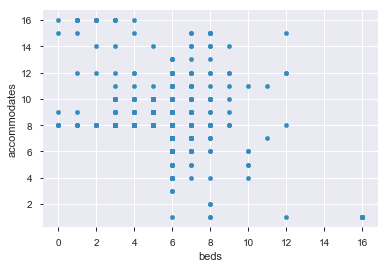

In [33]:
# checking correlation between 'beds' and 'accommodates'
cleaned_df[(cleaned_df.accommodates >= 8) | (cleaned_df.beds >= 6)].plot(kind = 'scatter', x = 'beds', y = 'accommodates')

The majority of listings data correlates well, but it is worth taking a look at the data along the axes, where one variable is low and the other one is high.

In [34]:
# checking data along y axis
cleaned_df[(cleaned_df.beds == 0)&(cleaned_df.accommodates >= 8)].loc[
    :,['price','beds', 'accommodates', 'property_type', 'room_type', 'name']]

price  beds  accommodates property_type        room_type  \
4160    290.0   0.0             9     Apartment  Entire home/apt   
5465    160.0   0.0             8          Loft  Entire home/apt   
6592    220.0   0.0             8     Apartment  Entire home/apt   
14723   340.0   0.0             8         House  Entire home/apt   
15262   600.0   0.0             8     Apartment  Entire home/apt   
26065   325.0   0.0             8     Apartment  Entire home/apt   
26249  1000.0   0.0            15         Other  Entire home/apt   
35187   390.0   0.0             8          Loft  Entire home/apt   
53598   400.0   0.0            16          Loft  Entire home/apt   

                                                    name  
4160                      Apartment & Terraces Paris XII  
5465          Loft Saint Germain dès Pres - Eiffel Tower  
6592   Charming apartment on Ile Saint-Louis (6-8 pers.)  
14723                Maison 120m2 rénovée, cour au calme  
15262     MARAIS Luxury 3 Bed , 2 bath Huge Garden View!  
26065     Bel appartement haussmannien Passy/Tour Eiffel  
26249         Les Showrooms du Marais - Commines (85 m2)  
35187         Loft avec terrasse en plein cœur du Marais  
53598             The ephemeral loft suitable for events

All seem to be large apartmens, mostly lofts that may not have beds and can be rented for events rather than stays.

In [35]:
# checking data along x axis
x = cleaned_df[(cleaned_df.accommodates <= 2)&(cleaned_df.beds >= 6)].loc[
    :,['price','beds', 'accommodates', 'property_type', 'room_type', 'name']]
x

price  beds  accommodates   property_type        room_type  \
29873   22.0  16.0             1       Apartment      Shared room   
30004   22.0  16.0             1     Condominium      Shared room   
30006   22.0  16.0             1     Condominium      Shared room   
30009   22.0  16.0             1     Condominium      Shared room   
30010   22.0  16.0             1     Condominium      Shared room   
30011   22.0  16.0             1     Condominium      Shared room   
30224   22.0  16.0             1     Condominium      Shared room   
30225   22.0  16.0             1     Condominium      Shared room   
30226   22.0  16.0             1     Condominium      Shared room   
30227   22.0  16.0             1     Condominium      Shared room   
30228   22.0  16.0             1     Condominium      Shared room   
30231   22.0  16.0             1     Condominium      Shared room   
30232   22.0  16.0             1     Condominium      Shared room   
41771   22.0  16.0             1     Condominium      Shared room   
52792   44.0   8.0             1          Hostel      Shared room   
53044   20.0  12.0             1  Boutique hotel     Private room   
53045   22.0   8.0             1  Boutique hotel     Private room   
56549   23.0   8.0             2       Apartment      Shared room   
56608   23.0   8.0             2       Apartment      Shared room   
57613  120.0   6.0             1       Apartment  Entire home/apt   

                                                    name  
29873                       . "Girl's Room" "限女性" "여자 방"  
30004                      .. "Girl's Room" "限女性" "여자 방"  
30006                     ... "Girl's Room" "限女性" "여자 방"  
30009                    .... "Girl's Room" "限女性" "여자 방"  
30010                   ..... "Girl's Room" "限女性" "여자 방"  
30011                  ...... "Girl's Room" "限女性" "여자 방"  
30224                                      Shared Room 1  
30225                                      Shared Room 2  
30226                                      Shared Room 3  
30227                                      Shared Room 4  
30228                                      Shared Room 6  
30231                                      Shared Room 7  
30232                                      Shared Room 8  
41771                                      Shared Room 5  
52792                                     Genrator Paris  
53044  Un lit superposé dans un dortoir de 12 personn...  
53045  Un lit superposé dans un dortoir de 8 personne...  
56549                                巴黎春天民宿8人间 女性专用间 房源8  
56608                                巴黎春天民宿8人间 女性专用间 房源7  
57613                  Apparement en plein triangle d’or

For shared room listings the number of beds indicates the total number of beds in the room, while the listing is typically just for 1 person. So I am keeping these rows. Similar are the listings in Boutique hotel as they are renting a space in the room. 

The data is now cleaned up for further analysis. I will store it in the file listings_cleansed.csv
I will also separately save series of listing ids to be used for cleaning other related datasets.

In [36]:
# writing cleaned data into the file
cleaned_df.to_csv('listings_cleaned.csv')

In [37]:
# writing Series of ids in a separate file
cleaned_df.id.to_csv('listing_ids.csv')

C:\Users\ksushka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
